# Chapter 24

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

In this chapter we model systems that involve rotating objects. 

## Rotation

Rotation is complicated: in three dimensions, objects can rotate around three axes; objects are often easier to spin around some
axes than others; and they may be stable when spinning around some axes but not others.

If the configuration of an object changes over time, it might become
easier or harder to spin, which explains the surprising dynamics of
gymnasts, divers, ice skaters, etc.

And when you apply a twisting force to a rotating object, the effect is often contrary to intuition. For an example, see this video on
gyroscopic precession <http://modsimpy.com/precess>.

In this chapter, we will not take on the physics of rotation in all its glory. Rather, we will focus on simple scenarios where all rotation and all twisting forces are around a single axis. In that case, we can treat some vector quantities as if they were scalars (in the same way that we sometimes treat velocity as a scalar with an implicit direction).

This approach makes it possible to simulate and analyze many interesting systems, but you will also encounter systems that would be better approached with the more general toolkit.

The fundamental ideas in this chapter and the next are **angular
velocity**, **angular acceleration**, **torque**, and **moment of
inertia**. If you are not already familiar with these concepts, I will
define them as we go along, and I will point to additional reading.

As a case study, you can use these tools to simulate the behavior of a yo-yo (see <http://modsimpy.com/yoyo>). But we'll work our way up to it gradually, starting with toilet paper.

## The physics of toilet paper

As a simple example of a system with rotation, we'll simulate the
manufacture of a roll of toilet paper, as shown in this video <https://youtu.be/Z74OfpUbeac?t=231>. Starting with a cardboard tube at the center, we will roll up 47 m of paper, the typical length of a roll of toilet paper in the U.S. (see <http://modsimpy.com/paper>).

![Diagram of a roll of toilet paper, showing change in paper length as a result of a small rotation, $d\theta$.](figs/paper_roll.pdf){height="2.5in"}

This figure shows a diagram of the system: $r$ represents
the radius of the roll at a point in time. Initially, $r$ is the radius of the cardboard core, $R_{min}$. When the roll is complete, $r$ is $R_{max}$.

I'll use $\theta$ to represent the total rotation of the roll in
radians. In the diagram, $d\theta$ represents a small increase in
$\theta$, which corresponds to a distance along the circumference of the roll of $r~d\theta$.

Finally, I'll use $y$ to represent the total length of paper that's been rolled. Initially, $\theta=0$ and $y=0$. For each small increase in $\theta$, there is a corresponding increase in $y$: 

$$dy = r~d\theta$$

If we divide both sides by a small increase in time, $dt$, we get a
differential equation for $y$ as a function of time.

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 

As we roll up the paper, $r$ increases, too. Assuming that $r$ increases by a fixed amount per revolution, we can write 

$$dr = k~d\theta$$ 

Where $k$ is an unknown constant we'll have to figure out. Again, we can divide both sides by $dt$ to get a differential equation in time:

$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$ 

Finally, let's assume that $\theta$ increases at a constant rate of $\omega = 300$ rad/s (about 2900 revolutions per minute): 

$$\frac{d\theta}{dt} = \omega$$ 

This rate of change is called an **angular velocity**. Now we have a system of three differential equations we can use to simulate the system.

## Implementation

At this point we have a pretty standard process for writing simulations like this.

First we'll create a `Params` object with the parameters of the system:

In [101]:
from modsim import units

m = units.meter
rad = units.radian
s = units.second

In [47]:
from modsim import Params

params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                L = 47 * m,
                theta_0 = 0 * rad,
                y_0 = 0 * m,
                omega = 300 * rad / s,
                t_end = 130 * s
               )

`Rmin` and `Rmax` are the initial and final values for the radius, `r`.
`L` is the total length of the paper. `t_end` is the length of the
simulation in time, and `dt` is the time step for the ODE solver.

We use the `Params` object to make a `System` object:

In [48]:
from modsim import State, System

def make_system(params):
    init = State(theta = params.theta_0,
                 y = params.y_0,
                 r = params.Rmin
                )
    
    k = estimate_k(params)

    return System(params,
                  init=init, 
                  k=k,
                 )

The initial state contains three variables, `theta`, `y`, and `r`.

`estimate_k` computes the parameter, `k`, that relates `theta` and `r`.
Here's how it works:

In [49]:
from numpy import pi

def estimate_k(params):
    Rmin, Rmax, L = params.Rmin, params.Rmax, params.L
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

`Ravg` is the average radius, half way between `Rmin` and `Rmax`, so
`Cavg` is the circumference of the roll when `r` is `Ravg`.

`revs` is the total number of revolutions it would take to roll up
length `L` if `r` were constant at `Ravg`. And `rads` is just `revs`
converted to radians.

Finally, `k` is the change in `r` for each radian of revolution. For
these parameters, `k` is about `2.8e-5` m/rad.

In [50]:
system = make_system(params)
system.init

theta      0 radian
y           0 meter
r        0.02 meter
dtype: object

In [51]:
system.k

2.7925531914893616e-05 <Unit('meter')>

Now we can use the differential equations from the previous section to
write a slope function:

In [52]:
def slope_func(t, state, system):
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

As usual, the slope function takes a `State` object, a time, and a
`System` object. The `State` object contains hypothetical values of
`theta`, `y`, and `r` at time `t`. The job of the slope function is to
compute the time derivatives of these values. The derivative of `theta` is angular velocity, which is often denoted `omega`.

And as usual, we'll test the slope function with the initial conditions.

In [53]:
slope_func(0, system.init, system)

(300.0 <Unit('radian / second')>,
 6.0 <Unit('meter * radian / second')>,
 0.008377659574468085 <Unit('meter * radian / second')>)

We'd like to stop the simulation when the length of paper on the roll is `L`. We can do that with an event function that passes through 0 when `y` equals `L`:

In [54]:
def event_func(t, state, system):
    theta, y, r = state
    return y - system.L

In [55]:
event_func(0, system.init, system)

-47 <Unit('meter')>

Now we can run the simulation like this:

In [56]:
from modsim import run_solve_ivp

results, details = run_solve_ivp(system, slope_func,
                                  events=event_func)
details.message

'A termination event occurred.'

Here are the last few time steps.

In [64]:
results.tail()

,theta,y,r
3.843556,1153.066667,41.625707,0.0522
3.927111,1178.133333,42.942960,0.0529
4.010667,1203.200000,44.277760,0.0536
4.094222,1228.266667,45.630107,0.0543
4.177778,1253.333333,47.000000,0.0550


At $\omega = 300$ rad/s, the time it takes to complete one roll is about 4.2 seconds, which is consistent with what we see in the video.

In [65]:
results.index[-1]

4.177777777777778

The final value of `y` is 47 meters, as expected.

In [19]:
final_state = results.iloc[-1] 
print(final_state.y, params.L)

47.0 47 meter


The final value of radius is `Rmax`.

In [20]:
print(final_state.r, params.Rmax)

0.05500000000000002 0.055 meter


And the total number of rotations is close to 200, which seems plausible.

In [21]:
radians = final_state.theta
rotations = radians / 2 / pi
rotations

199.47419534184226

As an exercise, we'll see how fast the paper is moving.  But first, let's take a closer look at the results.

## Plotting

Here's what `theta` looks like over time.

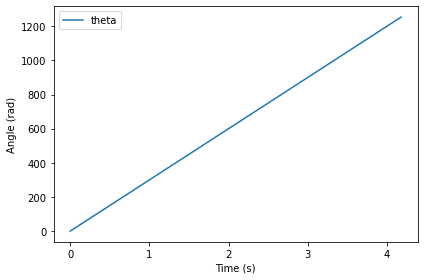

In [66]:
from modsim import decorate

def plot_theta(results):
    results.theta.plot(color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

`theta` grows linearly, as we should expect with constant angular velocity.

Here's what `r` looks like over time.

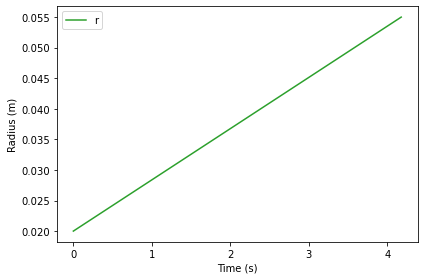

In [67]:
def plot_r(results):
    results.r.plot(color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

`r` also increases linearly.

But since the derivative of `y` depends on `r`, and `r` is increasing, `y` grows with increasing slope.

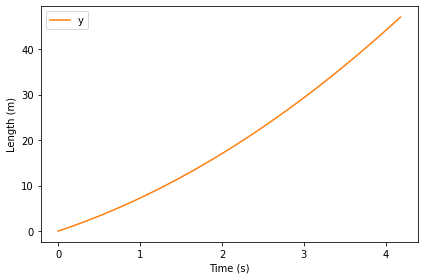

In [68]:
def plot_y(results):
    results.y.plot(color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Because this system is so simple, it is almost silly to simulate it; as we'll see in the next section, it is easy enough to solve the
differential equations analytically. 

However, it is often useful to start with simulation as a way of exploring and checking assumptions.

## Analysis

The differential equations in Section xx are simple enough that we can just solve them. Since angular velocity is constant: 

$$\frac{d\theta}{dt} = \omega$$ 

We can find $\theta$ as a function of time by integrating both sides:

$$\theta(t) = \omega t$$ 

Similarly, we can solve this equation

$$\frac{dr}{dt} = k \omega$$ 

to find

$$r(t) = k \omega t + R_{min}$$ 

Then we can plug the solution for $r$ into the equation for $y$: 

$$\begin{aligned}
\frac{dy}{dt} & = r \omega                      \\
              & = \left[ k \omega t + R_{min} \right] \omega \nonumber\end{aligned}$$
              
Integrating both sides yields:

$$y(t) = \left[ k \omega t^2 / 2 + R_{min} t \right] \omega$$ 

So $y$ is a parabola, as you might have guessed.

We can also use these equations to find the relationship between $y$ and $r$, independent of time, which we can use to compute $k$. Using a move we saw in Section xxx, I'll divide Equations 1 and
2, yielding

$$\frac{dr}{dy} = \frac{k}{r}$$ 

Separating variables yields

$$r~dr = k~dy$$ 

Integrating both sides yields 

$$r^2 / 2 = k y + C$$ 

When $y=0$, $r=R_{min}$, so 

$$C = \frac{1}{2} R_{min}^2$$ 

Solving for $y$, we have 

$$y = \frac{1}{2k} (r^2 - R_{min}^2)                 \label{eqn3}$$

When $y=L$, $r=R_{max}$; substituting in those values yields

$$L = \frac{1}{2k} (R_{max}^2 - R_{min}^2)$$ 

Solving for $k$ yields

$$k =  \frac{1}{2L} (R_{max}^2 - R_{min}^2)           \label{eqn4}$$

Plugging in the values of the parameters yields `2.8e-5` m/rad, the same as the "estimate" we computed in Section xxx. 

In [72]:
k = (params.Rmax**2 - params.Rmin**2) / (2 * params.L)
print(k, system.k)

2.7925531914893616e-05 meter 2.7925531914893616e-05 meter


In this case the estimate turns out to be exact.

## Summary

### Exercises

**Exercise:** Since we keep `omega` constant, the linear velocity of the paper increases with radius.  We can use `gradient` to estimate the derivative of `results.y`.

In [73]:
# Solution

from modsim import gradient

dydt = gradient(results.y);

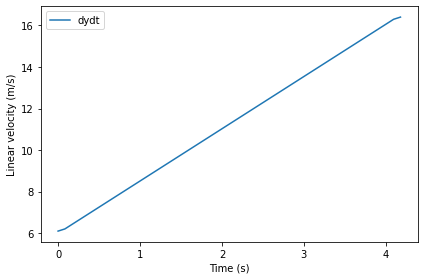

In [90]:
# Solution

dydt.plot(label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

With constant angular velocity, linear velocity is increasing, reaching its maximum at the end.

In [92]:
max_linear_velocity = dydt.iloc[-1]
max_linear_velocity

16.394999999999992

Now suppose this peak velocity is the limiting factor; that is, we can't move the paper any faster than that.

Nevertheless, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.

Run the simulation and see how much faster we could finish rolling the paper.

In [93]:
# Solution

def slope_func(t, state, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = system.linear_velocity
    omega = dydt / r
    drdt = k * omega
    
    return omega, dydt, drdt

In [94]:
# Solution

system.linear_velocity = max_linear_velocity
slope_func(0, system.init, system)

(819.7499999999997 <Unit('1 / meter')>,
 16.394999999999992,
 0.02289195478723403 <Unit('dimensionless')>)

In [95]:
# Solution

results, details = run_solve_ivp(system, slope_func, 
                                 events=event_func)
details.message

'A termination event occurred.'

In [96]:
# Solution

t_final = results.index[-1]
t_final

2.8667276608722188

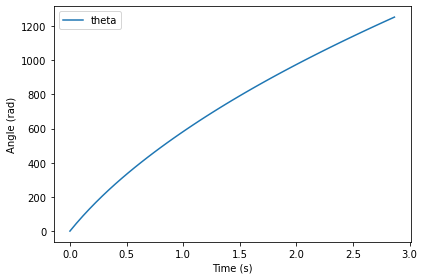

In [97]:
# Solution

plot_theta(results)

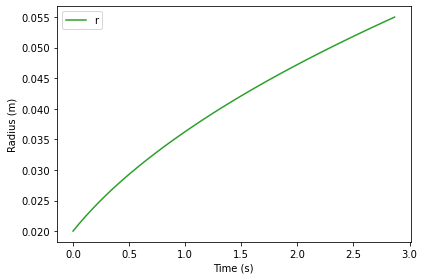

In [98]:
# Solution

plot_r(results)

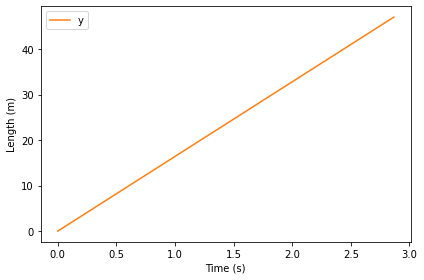

In [99]:
# Solution

plot_y(results)